In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk # data mining tools
import matplotlib.pylab as plt # plotting
import seaborn as sns # advanced plotting
from pandas.tools.plotting import scatter_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
indiana = pd.read_csv("diabetes.csv")
indiana.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Data cleanining

In [3]:
(indiana == 0).sum() #cerco il numero di zeri per ogni colonna.

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [4]:
cols = ["Glucose","BloodPressure","BMI","SkinThickness","Insulin"]
indiana[cols] = indiana[cols].replace({0:np.nan})
indiana["Insulin"] = [x if 4 <= x <= 250 else np.nan for x in indiana["Insulin"]]
indiana["SkinThickness"] = [x if x <= 50 else np.nan for x in indiana["SkinThickness"]]
indiana['Glucose'] = indiana['Glucose'].fillna(indiana['Glucose'].median())
indiana['BMI'] = indiana['BMI'].fillna(indiana['BMI'].median())
indiana['BloodPressure'] = indiana['BloodPressure'].fillna(indiana['BloodPressure'].median())

In [5]:
indiana.isnull().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                 0
SkinThickness               236
Insulin                     430
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [6]:
indiana.describe(include='all')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,532.000000,338.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,28.629699,117.000000,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,9.574374,56.083659,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,21.000000,71.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,110.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,36.000000,159.750000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,50.000000,250.000000,67.100000,2.420000,81.000000,1.000000


Poiché le colonne *insulin* e *skinThickness* hanno moltissimi valori nulli, per lo studio di classificazione procederemo in 2 modi: in un primo studio andremo a eseguire il task considerando tutte le features, ma conservando solamente le righe in cui i valori di queste due colonne sono non nulli; nel secondo caso, proveremo a eseguire la classificazione considerando tutte le righe, ma eliminando queste due colonne.

Un'altra possibilità consiste nel sostituire i valori mancanti andando a generare una distribuzione gaussiana centrata nella media della colonna di interesse.

In [7]:
indiana['Insulin'].isnull().groupby(indiana['Outcome']).sum()

Outcome
0    263.0
1    167.0
Name: Insulin, dtype: float64

In [8]:
# Insulin:
media = list(indiana['Insulin'].groupby(indiana['Outcome']).mean())
std = list(indiana['Insulin'].groupby(indiana['Outcome']).std())
num = list(indiana['Insulin'].isnull().groupby(indiana['Outcome']).sum())

punti_0 = list(np.random.normal(media[0], std[0], int(num[0])))
punti_1 = list(np.random.normal(media[1], std[1], int(num[1])))

to_sub0 = indiana['Insulin'][indiana.Outcome == 0]
to_sub0[(np.isnan(indiana['Insulin']))] = punti_0
to_sub1 = indiana['Insulin'][indiana.Outcome == 1]
to_sub1[(np.isnan(indiana['Insulin']))] = punti_1

i = pd.concat([to_sub0, to_sub1])
indiana['Insulin'] = i
indiana.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,133.178757,33.6,0.627,50,1
1,1,85.0,66.0,29.0,40.304815,26.6,0.351,31,0
2,8,183.0,64.0,NaN,153.546739,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.000000,43.1,2.288,33,1


In [9]:
# Skin:
media_s = list(indiana['SkinThickness'].groupby(indiana['Outcome']).mean())
std_s = list(indiana['SkinThickness'].groupby(indiana['Outcome']).std())
num_s = list(indiana['SkinThickness'].isnull().groupby(indiana['Outcome']).sum())

punti_0s = list(np.random.normal(media_s[0], std_s[0], int(num_s[0])))
punti_1s = list(np.random.normal(media_s[1], std_s[1], int(num_s[1])))

to_sub0s = indiana['SkinThickness'][indiana.Outcome == 0]
to_sub0s[(np.isnan(indiana['SkinThickness']))] = punti_0s
to_sub1s = indiana['SkinThickness'][indiana.Outcome == 1]
to_sub1s[(np.isnan(indiana['SkinThickness']))] = punti_1s

a = pd.concat([to_sub0s, to_sub1s])
indiana['SkinThickness'] = a
indiana.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,133.178757,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,40.304815,26.6,0.351,31,0
2,8,183.0,64.0,15.105449,153.546739,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


In [10]:
indiana.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [11]:
indiana.describe(include='all')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,28.464105,117.596113,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,9.715679,55.115873,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,2.307202,-64.558820,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,21.241735,76.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.835088,114.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,35.000000,156.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,56.067199,266.864961,67.100000,2.420000,81.000000,1.000000


In [12]:
#gestisco eventuali valori random <= 0:
(indiana <= 0).sum()

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       4
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [13]:
indiana["Insulin"] = [x if x > 10 else indiana['Insulin'].median() for x in indiana["Insulin"]]
indiana["SkinThickness"] = [x if x>4 else indiana["SkinThickness"].median() for x in indiana["SkinThickness"]]
indiana.describe(include='all')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,28.533188,118.493314,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,9.623198,53.865456,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,5.316560,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,21.362518,76.518895,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.917544,114.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,35.000000,156.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,56.067199,266.864961,67.100000,2.420000,81.000000,1.000000


In [14]:
#indiana = pd.read_csv("diabetes-cleaned.csv")
#indiana.describe()

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Classification - case 1

In [16]:
df1 = indiana.dropna(axis=0)
df1.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,133.178757,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,40.304815,26.6,0.351,31,0
2,8,183.0,64.0,15.105449,153.546739,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


In [17]:
df1.groupby(df1.Outcome).count()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,500,500,500,500,500,500,500,500
1,268,268,268,268,268,268,268,268


Train/Test splitting:

In [18]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
attributes = [col for col in df1.columns if col != 'Outcome']
X = df1[attributes].values
s = StandardScaler()
X = s.fit_transform(X) #rescaling the values
y = df1['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

### Cross-validation:

*StratifiedKFold* provides train/test indices to split data in train/test sets.
This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [20]:
cv = StratifiedKFold(n_splits=10, shuffle=True,random_state=0)

### Parameter tuning:

In [21]:
param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
             }

random_search_dt = RandomizedSearchCV(dtc, param_distributions=param_list, n_iter=100, cv = cv, scoring = 'accuracy')
random_search_dt.fit(X, y)
best_score = random_search_dt.best_score_
best_params = random_search_dt.best_params_
print("Best score: {}, Best parameters: {}".format(best_score, best_params))

Best score: 0.79296875, Best parameters: {'min_samples_split': 50, 'min_samples_leaf': 10, 'max_depth': 16}


In [22]:
clf_dt = random_search_dt.best_estimator_

### Perform Classification:

In [23]:
clf_dt = clf_dt.fit(X_train, y_train)
y_pred = clf_dt.predict(X_test)
y_pred_tr = clf_dt.predict(X_train)

### Analyze the classification results:

In [24]:
for col, imp in zip(attributes, clf_dt.feature_importances_):
    print(col, imp)

Pregnancies 0.0
Glucose 0.4899810979960758
BloodPressure 0.006468543668542284
SkinThickness 0.07061808405748726
Insulin 0.1607084626684315
BMI 0.1089491681256213
DiabetesPedigreeFunction 0.0397391772472523
Age 0.12353546623658954


Visualizing the DecisionTree:

In [25]:
import pydotplus
from sklearn import tree
from IPython.display import Image

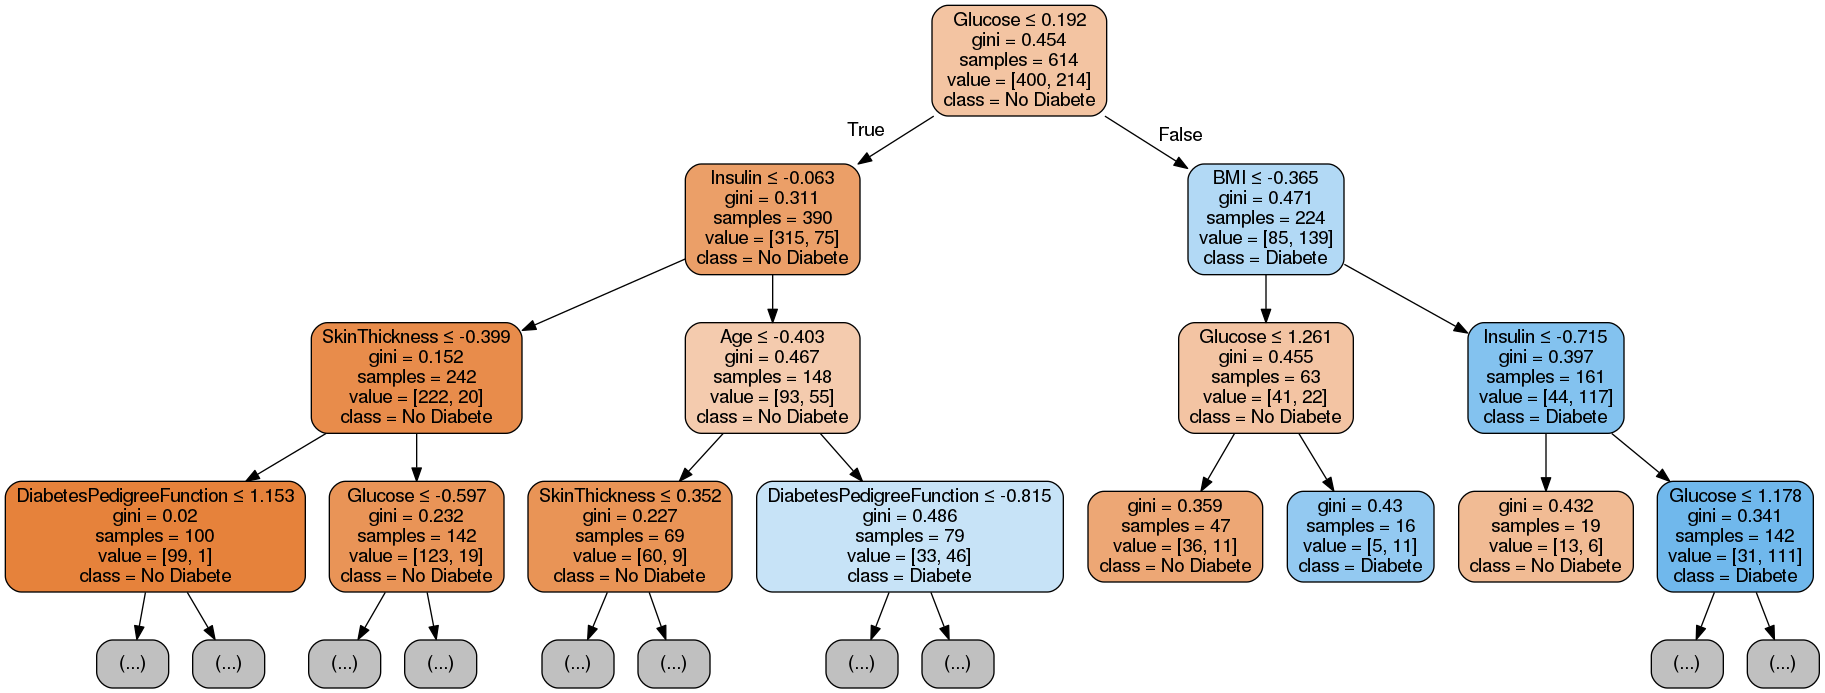

In [26]:
dot_data = tree.export_graphviz(clf_dt, out_file=None,
                                feature_names=attributes,
                                class_names=['Diabete' if x == 1 else 'No Diabete' for x in clf_dt.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### Analyze the performance:

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

Performance on the training set:

In [28]:
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print(classification_report(y_train, y_pred_tr))
print("Confusion Matrix:\n",confusion_matrix(y_train, y_pred_tr))

Train Accuracy 0.8355048859934854
Train F1-score [0.87515451 0.75894988]
             precision    recall  f1-score   support

          0       0.87      0.89      0.88       400
          1       0.78      0.74      0.76       214

avg / total       0.83      0.84      0.83       614

Confusion Matrix:
 [[354  46]
 [ 55 159]]


Performance on the test set:

In [29]:
print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))

Test Accuracy 0.7922077922077922
Test F1-score [0.83157895 0.72881356]
             precision    recall  f1-score   support

          0       0.88      0.79      0.83       100
          1       0.67      0.80      0.73        54

avg / total       0.81      0.79      0.80       154

Confusion Matrix:
 [[79 21]
 [11 43]]


### ROC curve:

In [30]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)
roc_auc

0.7931481481481482


0.7931481481481482

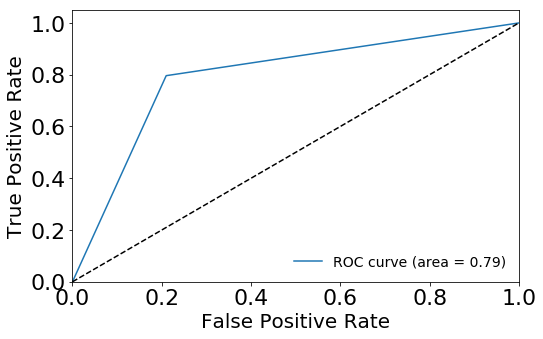

In [31]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

## Support Vector Machine:

Radial Basis Function is a commonly used kernel in SVC:
$$K(x,x') = exp\left(-\frac{\parallel x-x'\parallel^2}{2\gamma^2}\right)$$
where $\parallel x-x'\parallel^2$ is the squared Euclidean distance between two data points 
x and x', while ***C*** and ***gamma*** are two fundamental parameters for the SVC classifier using an RBF kernel.
- **gamma:**

gamma is a parameter of the RBF kernel and can be thought of as the ‘spread’ of the kernel and therefore the decision region. When gamma is low, the ‘curve’ of the decision boundary is very low and thus the decision region is very broad. When gamma is high, the ‘curve’ of the decision boundary is high, which creates islands of decision-boundaries around data points. We will see this very clearly below.

- **C:**

C is a parameter of the SVC learner and is the penalty for misclassifying a data point. When C is small, the classifier is okay with misclassified data points (high bias, low variance). When C is large, the classifier is heavily penalized for misclassified data and therefore bends over backwards avoid any misclassified data points (low bias, high variance).

In [32]:
from sklearn.svm import SVC
svc = SVC(kernel = 'rbf', class_weight = 'balanced')

### Cross-validation:

*StratifiedKFold* provides train/test indices to split data in train/test sets.
This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [33]:
cv = StratifiedKFold(n_splits=10, shuffle=True,random_state=0)

### Parameter Tuning:

In [34]:
param_list = {'gamma': np.logspace(-4,0,100, base=10),
              'C': np.logspace(0,3,100, base=10)
             }

random_search_svm = RandomizedSearchCV(svc, param_distributions=param_list, n_iter=100, cv = cv, scoring = 'accuracy')
random_search_svm.fit(X, y)
best_score = random_search_svm.best_score_
best_params = random_search_svm.best_params_
print("Best score: {}, Best parameters: {}".format(best_score, best_params))

Best score: 0.7877604166666666, Best parameters: {'gamma': 0.08111308307896872, 'C': 1.7475284000076838}


In [35]:
clf_svm = random_search_svm.best_estimator_

### Perform the classification:

In [36]:
clf_svm = clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)
y_pred_tr = clf_svm.predict(X_train)

See the evaluation:

### Analyze the performance:

Performance on the training set:

In [37]:
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print(classification_report(y_train, y_pred_tr))
print("Confusion Matrix:\n",confusion_matrix(y_train, y_pred_tr))

Train Accuracy 0.8371335504885994
Train F1-score [0.86842105 0.78632479]
             precision    recall  f1-score   support

          0       0.92      0.82      0.87       400
          1       0.72      0.86      0.79       214

avg / total       0.85      0.84      0.84       614

Confusion Matrix:
 [[330  70]
 [ 30 184]]


Performance on the test set:

In [38]:
print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))

Test Accuracy 0.7922077922077922
Test F1-score [0.82222222 0.75      ]
             precision    recall  f1-score   support

          0       0.93      0.74      0.82       100
          1       0.65      0.89      0.75        54

avg / total       0.83      0.79      0.80       154

Confusion Matrix:
 [[74 26]
 [ 6 48]]


### ROC curve:

In [39]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)
roc_auc

0.8144444444444444


0.8144444444444444

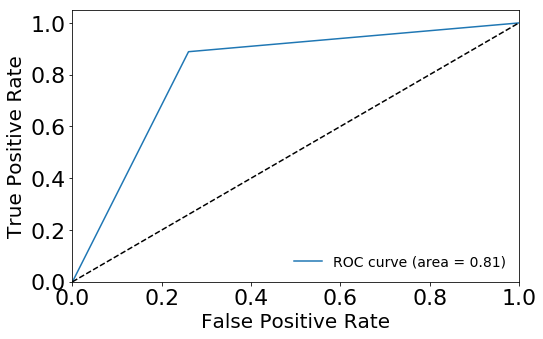

In [40]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

## RandomForest

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
cv = StratifiedKFold(n_splits=10, shuffle=True,random_state=0)

In [43]:
param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
             }

rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                             min_samples_split=2, min_samples_leaf=1, class_weight=None)

random_search_rf = RandomizedSearchCV(rf, param_distributions=param_list, n_iter=100, cv = cv, scoring = 'accuracy')
random_search_rf.fit(X, y)
best_score = random_search_rf.best_score_
best_params = random_search_rf.best_params_

print("Best score: {}, Best parameters: {}".format(best_score, best_params))

Best score: 0.8111979166666666, Best parameters: {'min_samples_split': 30, 'min_samples_leaf': 1, 'max_depth': 16}


In [44]:
clf_rf = random_search_rf.best_estimator_

clf_rf = clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
y_pred_tr = clf_rf.predict(X_train)

In [45]:
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print(classification_report(y_train, y_pred_tr))
print("Confusion Matrix:\n",confusion_matrix(y_train, y_pred_tr))

Train Accuracy 0.8827361563517915
Train F1-score [0.91219512 0.82352941]
             precision    recall  f1-score   support

          0       0.89      0.94      0.91       400
          1       0.87      0.79      0.82       214

avg / total       0.88      0.88      0.88       614

Confusion Matrix:
 [[374  26]
 [ 46 168]]


In [46]:
print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))

Test Accuracy 0.8116883116883117
Test F1-score [0.85572139 0.72897196]
             precision    recall  f1-score   support

          0       0.85      0.86      0.86       100
          1       0.74      0.72      0.73        54

avg / total       0.81      0.81      0.81       154

Confusion Matrix:
 [[86 14]
 [15 39]]


In [47]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)
roc_auc

0.7911111111111112


0.7911111111111112

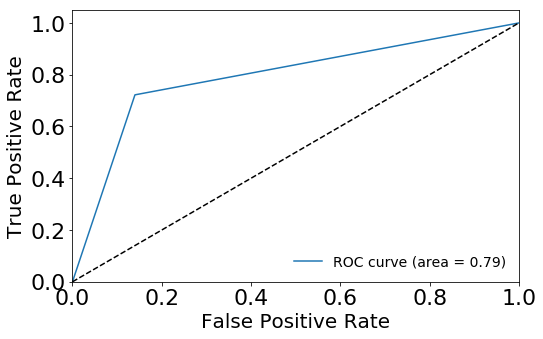

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()